# Sales Prediction for Big Mart Outlets

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly. 

## Importing Libraries

In [1]:
import pandas as pd
import numpy  as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error
from pandas_profiling import ProfileReport
# Comment this if the data visualisations doesn't work on your side
%matplotlib inline
plt.style.use('bmh')

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Loading Train and Test Data

In [3]:
df_train = pd.read_csv('train_BM.csv')
df_test = pd.read_csv('test_BM.csv')
df_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## EDA

In [4]:
profile = ProfileReport(df_train,title='Profile Report',explorative=True)
profile.to_widgets()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64


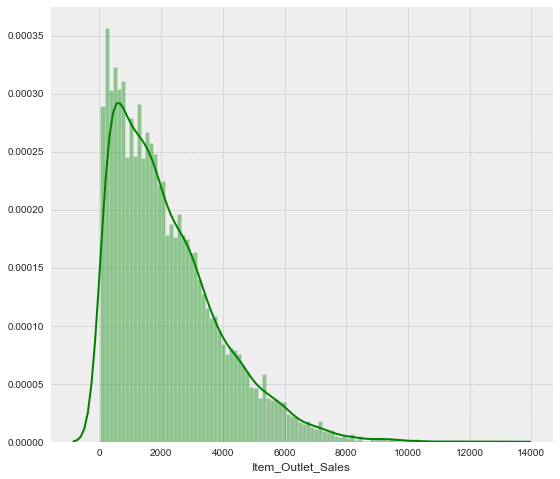

In [5]:
print(df_train['Item_Outlet_Sales'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df_train['Item_Outlet_Sales'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Data Pre-Processing

In [319]:
# Merging Train and Test Dataset
df_train['source']='train'
df_test['source']='test'
merge_data = pd.concat([df_train,df_test], ignore_index = True)
print(df_train.shape, df_test.shape, merge_data.shape)

(8523, 13) (5681, 12) (14204, 13)


### Merging Same categories into common names

In [320]:
merge_data['Item_Fat_Content'].value_counts()

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

In [321]:
merge_data['Item_Fat_Content'] = merge_data['Item_Fat_Content'].str.replace('low fat','Low Fat')
merge_data['Item_Fat_Content'] = merge_data['Item_Fat_Content'].str.replace('LF','Low Fat')
merge_data['Item_Fat_Content'] = merge_data['Item_Fat_Content'].str.replace('reg','Regular')
merge_data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

### Imputing Missing Values with custom method

In [322]:
# Finding the null values.
print(merge_data.isnull().sum())

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64


In [323]:
def custom_replace(x):
    if math.isnan(x['Item_Weight']): 
        wt = merge_data[(merge_data['Item_Type'] == x['Item_Type']) & (merge_data['Item_Weight'].isnull() == False )]
        return merge_data['Item_Weight'].mean() if wt['Item_Weight'].empty else wt['Item_Weight'].iloc[0]
    else:
        return x['Item_Weight']
    
# Replacing item_weight values with custom replace method        
merge_data['Item_Weight'] = merge_data.apply(lambda x: custom_replace(x),axis=1)

# Imputing outlet_size with mode method
outlet_size_mode = merge_data['Outlet_Size'].value_counts().index[0]
merge_data['Outlet_Size'].fillna(outlet_size_mode,inplace=True)
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                14204 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                14204 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
 12  source                     14204 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usag

# Feature Engineering

### Imputing 0's in Item_Visibility with Mean values

In [324]:
# replace all 0's Item_Visibility with mean of Item_Visibility
val = merge_data['Item_Visibility'].mean()
merge_data['Item_Visibility'] = merge_data['Item_Visibility'].replace(to_replace=0.000000, value=val)
merge_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.065953,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.065953,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


### New Feature generation 

In [325]:
merge_data['Item_mrp_x_Visibility'] = merge_data['Item_Visibility'] * merge_data['Item_MRP']
merge_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_mrp_x_Visibility
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,4.008763
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.930544
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,2.373528
3,FDX07,19.20,Regular,0.065953,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,train,12.009671
4,NCD19,8.93,Low Fat,0.065953,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,3.552309


### Converting established_date to Age of the outlet

In [326]:
merge_data['Outlet_Years'] = 2013 - merge_data['Outlet_Establishment_Year']
merge_data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

### Merging item_type categories by mapping into common item type

In [327]:
#Get the first two characters of ID:
merge_data['Item_Type_Combined'] = merge_data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
merge_data['Item_Type_Combined'] = merge_data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
merge_data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [328]:
#Mark non-consumables as separate category in low_fat:
merge_data.loc[merge_data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
merge_data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

### Quantile based binning for Item_weight

In [329]:
merge_data['Item_Weight'].describe()

count    14204.000000
mean        13.009974
std          4.646273
min          4.555000
25%          8.930000
50%         12.800000
75%         17.200000
max         21.350000
Name: Item_Weight, dtype: float64

In [330]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = merge_data['Item_Weight'].quantile(quantile_list)
quantiles

0.00     4.555
0.25     8.930
0.50    12.800
0.75    17.200
1.00    21.350
Name: Item_Weight, dtype: float64

In [331]:
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
merge_data['Item_Weight'] = pd.qcut(merge_data['Item_Weight'],q=quantile_list, labels=quantile_labels)
merge_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_mrp_x_Visibility,Outlet_Years,Item_Type_Combined
0,FDA15,25-50Q,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,4.008763,14,Food
1,DRC01,0-25Q,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,0.930544,4,Drinks
2,FDN15,75-100Q,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,2.373528,14,Food
3,FDX07,75-100Q,Regular,0.065953,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,train,12.009671,15,Food
4,NCD19,0-25Q,Non-Edible,0.065953,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,3.552309,26,Non-Consumable


## Label Encoding categorical features

In [332]:
def label_encoder(data):
    le = preprocessing.LabelEncoder()
    data = le.fit_transform(data)
    return data

merge_data['Outlet'] = label_encoder(merge_data['Outlet_Identifier'])
merge_data['Item_Fat_Content'] = label_encoder(merge_data['Item_Fat_Content'])
merge_data['Outlet_Size'] = label_encoder(merge_data['Outlet_Size'])
merge_data['Outlet_Location_Type'] = label_encoder(merge_data['Outlet_Location_Type'])
merge_data['Outlet_Type'] = label_encoder(merge_data['Outlet_Type'])
merge_data['Item_Type_Combined'] = label_encoder(merge_data['Item_Type_Combined'])
merge_data['Item_Weight'] = label_encoder(merge_data['Item_Weight'])
merge_data.drop(['Item_Type','Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'],axis=1, inplace=True)

merge_data.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Item_mrp_x_Visibility,Outlet_Years,Item_Type_Combined,Outlet
0,1,0,0.016047,249.8092,1,0,1,3735.1380,train,4.008763,14,1,9
1,0,2,0.019278,48.2692,1,2,2,443.4228,train,0.930544,4,0,3
2,3,0,0.016760,141.6180,1,0,1,2097.2700,train,2.373528,14,1,9
3,3,2,0.065953,182.0950,1,2,0,732.3800,train,12.009671,15,1,0
4,0,1,0.065953,53.8614,0,2,1,994.7052,train,3.552309,26,2,1


## Splitting up train and test Data

In [411]:
#Divide into test and train:
X = merge_data[merge_data['source']=="train"]
test = merge_data[merge_data['source']=="test"]

#Drop unnecessary columns:
y = X['Item_Outlet_Sales'].values
test.drop(['source','Item_Outlet_Sales'],axis=1,inplace=True)
X.drop(['source','Item_Outlet_Sales'],axis=1,inplace=True)

category_col = ['Item_Weight','Item_Fat_Content','Outlet_Type','Outlet','Outlet_Location_Type']

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.01,shuffle=True,random_state=99)
print("Size of X_train ", X_train.shape)
print("Size of X_cv ", X_cv.shape)
print("Size of y_train ", y_train.shape)
print("Size of y_cv ", y_cv.shape)

Size of X_train  (8437, 11)
Size of X_cv  (86, 11)
Size of y_train  (8437,)
Size of y_cv  (86,)


## Evaluation : Performance Metrics - RMSE

In [222]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Model Training , Prediction and Evaluation

## LGBM Regressor

In [412]:
from tqdm.notebook import tqdm ,tnrange
import lightgbm as LGBMRegressor

params= { }
params['learning_rate'] = 0.01
params['n_estimators']= 950
params['max_depth']= 3
params['lambda_l2']=7
params['metric'] = 'rmse'
params['seed']= 99
params['cat_features'] = category_col
params['regression_l1'] = 10
params['objective'] = 'regression'
params['n_jobs'] = -1
params['max_bin'] = 800

scores = []
splits = KFold(n_splits=285,random_state=99)

for i, (idxT, idxV) in enumerate(splits.split(X, y)):

        print('Fold',i)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        # Training
        d_train = LGBMRegressor.Dataset(X.iloc[idxT], label=y[idxT])
        clf =  LGBMRegressor.train(params,d_train,50)
        
        # Prediction
        probs_oof = clf.predict(X.iloc[idxV])
        
        # Evaluation
        rmse = np.sqrt(mean_squared_error(y[idxV],probs_oof))
        scores.append(rmse)

        print ('LGBM Val OOF RMSE =',rmse)
        print('#'*100)
print('RMSE Mean Score : ')
print('%.8f (%.8f)' % (np.array(scores).mean(), np.array(scores).std()))

Fold 0
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 715.3685011255773
####################################################################################################
Fold 1
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1263.8340557061533
####################################################################################################
Fold 2
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1239.3154027429916
####################################################################################################
Fold 3
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1196.5944196859823
####################################################################################################
Fold 4
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1288.6167877822736
####################################################################################################
Fold 5
 rows of train = 8493 rows of holdout = 30
L

LGBM Val OOF RMSE = 746.2099445365327
####################################################################################################
Fold 44
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1246.7670950748743
####################################################################################################
Fold 45
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 995.3659588139088
####################################################################################################
Fold 46
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 779.5069189036641
####################################################################################################
Fold 47
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 930.6148092290009
####################################################################################################
Fold 48
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1553.1789026639917
##########

LGBM Val OOF RMSE = 741.3226394754857
####################################################################################################
Fold 88
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1200.8439371261102
####################################################################################################
Fold 89
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1127.9093232413243
####################################################################################################
Fold 90
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 814.2468203243776
####################################################################################################
Fold 91
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 892.5889497747166
####################################################################################################
Fold 92
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1135.5629282399282
#########

LGBM Val OOF RMSE = 882.8809834524485
####################################################################################################
Fold 131
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 897.2118857393068
####################################################################################################
Fold 132
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1222.8820693497114
####################################################################################################
Fold 133
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1018.5868301406457
####################################################################################################
Fold 134
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1112.835574056059
####################################################################################################
Fold 135
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1016.7121724782054
####

LGBM Val OOF RMSE = 969.2603499819029
####################################################################################################
Fold 174
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1466.643233359494
####################################################################################################
Fold 175
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1203.748462083362
####################################################################################################
Fold 176
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1232.0401259161401
####################################################################################################
Fold 177
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1285.1724305853677
####################################################################################################
Fold 178
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 878.1980386065569
#####

LGBM Val OOF RMSE = 1056.6937588316682
####################################################################################################
Fold 217
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1340.1662066172764
####################################################################################################
Fold 218
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1544.0127184599978
####################################################################################################
Fold 219
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 744.1117839632593
####################################################################################################
Fold 220
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1070.7598533854703
####################################################################################################
Fold 221
 rows of train = 8493 rows of holdout = 30
LGBM Val OOF RMSE = 1261.0078312858625
##

LGBM Val OOF RMSE = 1065.4003252800676
####################################################################################################
Fold 260
 rows of train = 8494 rows of holdout = 29
LGBM Val OOF RMSE = 1346.5850108720006
####################################################################################################
Fold 261
 rows of train = 8494 rows of holdout = 29
LGBM Val OOF RMSE = 1133.9537582453138
####################################################################################################
Fold 262
 rows of train = 8494 rows of holdout = 29
LGBM Val OOF RMSE = 1188.3571642060422
####################################################################################################
Fold 263
 rows of train = 8494 rows of holdout = 29
LGBM Val OOF RMSE = 1022.735589510129
####################################################################################################
Fold 264
 rows of train = 8494 rows of holdout = 29
LGBM Val OOF RMSE = 1251.7237816224776
##

## Model Interpretation and Analysis using SHAP

In [413]:
import shap
# print the JS visualization code to the notebook
shap.initjs()


In [414]:
# explain the GAM model with SHAP
background = shap.maskers.Independent(X_cv, max_samples=1000)
explainer_ebm = shap.Explainer(clf.predict, background)
shap_values_ebm = explainer_ebm(X_cv.iloc[:5])

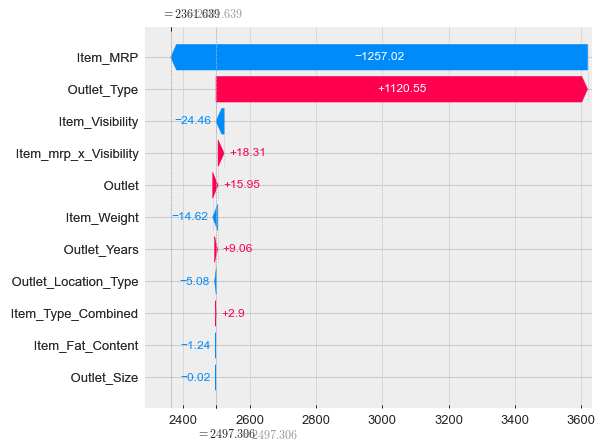

In [419]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[3], max_display=12)

### Shap Summary Plot

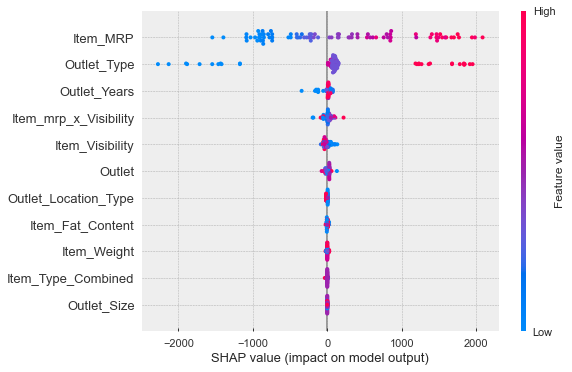

In [420]:
# explain all the predictions in the test set
ex = shap.TreeExplainer(clf)
shap_values = ex.shap_values(X_cv)
shap.summary_plot(shap_values, X_cv)

In the above graph, the features have been stacked in descending order of importance.
Red indicates high feature value and Blue indicates low feature value. 
We know that the more positive the SHAP value, 
the more is the contribution of that feature as SHAP value calculates the difference between predictions 
with the feature and without the feature. 
Thus, RED color corresponds to +SHAP and the feature is positively correlated to the target variable and 
if BLUE color corresponds to –SHAP, it is negatively correlated to the target variable.

### Shap Force Plot for one sample Data

In [424]:
ex = shap.TreeExplainer(clf)
shap_values = ex.shap_values(X_cv)
shap.force_plot(ex.expected_value, 
                shap_values[1], 
                X_cv.iloc[3])

In the graph, the base value is used to depict the output of a baseline model without any features. For a regression model, it is the average of the model output over the training data.

Features that push the prediction to the right of base value are shown in red, and those pushing the prediction towards the base value are in blue.

### Shap Force Plot for all Datapoint in training dataset

In [425]:
shap.force_plot(ex.expected_value, shap_values, X_cv)

Force_plot can also be used to explain the entire dataset. It is nothing but the same plot for each sample, rotated 90 degrees and stacked side-by-side to explain the predictions for multiple samples in a single plot.

The color codes mean the same as in previous chart, with red colored features increasing the logit & the blue colored feature decreasing the logit for each data point.

## Feature Selection

####  1) As per the above summary plot we can observe 'Outlet_Size','Item_Type_Combined' features have less impact on model output.
####  2) By removing the less impacted feature 'Outlet_Size','Item_Type_Combined' and training the model gave lowest RMSE score.

## Predicting on Test data

In [373]:
test.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Location_Type,Outlet_Type,Item_mrp_x_Visibility,Outlet_Years,Outlet
8523,3,0,0.007565,107.8622,0,1,0.815960,14,9
8524,0,2,0.038428,87.3198,1,1,3.355497,6,2
8525,2,1,0.099575,241.7538,2,0,24.072612,15,0
8526,0,0,0.015388,155.0340,1,1,2.385724,6,2
8527,1,2,0.118599,234.2300,2,3,27.779517,28,5


In [393]:
y_pred =  clf.predict(test)
y_pred

array([1639.15282751, 1371.66500047,  486.81594068, ..., 1864.60123005,
       3570.47301744, 1291.55638507])

In [394]:
final_df = pd.DataFrame(df_test['Item_Identifier'],columns=['Item_Identifier',])
final_df = pd.concat([final_df,df_test['Outlet_Identifier']],axis=1)
final_df['Item_Outlet_Sales'] = y_pred
final_df.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1639.152828
1,FDW14,OUT017,1371.665000
2,NCN55,OUT010,486.815941
3,FDQ58,OUT017,2515.166360
4,FDY38,OUT027,6138.777165


In [395]:
final_df.to_csv('bigmart_lgbm_12.csv',index=False)